In [2]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
import datetime
import numpy as np
import argparse
from torchsummary import summary

In [100]:
num_epochs = 20
batch_size = 2048
learning_rate = 1e-3

train_transform = transforms.Compose([transforms.ToTensor()])
train_set = MNIST('./data/mnist', train=True, download=True, transform=train_transform)
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
device = torch.device('cuda')

# idx = int(input("Pick a number: "))

# plt.imshow(train_set.data[idx], cmap='gray')
# plt.show()

In [101]:
class autoencoderMLP4(nn.Module):
    def __init__(self, N_input=784, N_bottleneck=16, N_output=784):
        super(autoencoderMLP4, self).__init__()
        N2 = 392
        self.fc1 = nn.Linear(N_input, N2)
        self.fc2 = nn.Linear(N2, N_bottleneck)
        self.fc3 = nn.Linear(N_bottleneck, N2)
        self.fc4 = nn.Linear(N2, N_output)
        self.type = "MLP4"
        self.input_shape = (1, 28*28)
        
    def forward(self, X):
        X = self.fc1(X)
        X = F.relu(X)
        X = self.fc2(X)

        X = self.fc3(X)
        X = F.relu(X)
        X = self.fc4(X)
        X = torch.sigmoid(X)

        return X

In [102]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, scheduler, device):
    model.train().to(device)
    losses_train = []
    
    for epoch in range(1, n_epochs+1):
        print('epoch ', epoch)
        loss_train = 0.0
        for imgs in train_loader:
            img, _ = imgs
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            outputs = model(img).to(device)
            loss = loss_fn(outputs, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        scheduler.step(loss_train)

        losses_train += [loss_train/len(train_loader)]

        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    plt.style.use('fivethirtyeight')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(losses_train[-100:])
    plt.show()

epoch  1


/home/sinan/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


2023-09-13 11:06:51.539346 Epoch 1, Training loss 0.10537955711285273
epoch  2
2023-09-13 11:06:55.943117 Epoch 2, Training loss 0.06547192384799322
epoch  3
2023-09-13 11:07:00.463328 Epoch 3, Training loss 0.052385929971933365
epoch  4
2023-09-13 11:07:04.993831 Epoch 4, Training loss 0.044797809918721516
epoch  5
2023-09-13 11:07:09.624030 Epoch 5, Training loss 0.03904804860552152
epoch  6
2023-09-13 11:07:14.092458 Epoch 6, Training loss 0.03504988327622414
epoch  7
2023-09-13 11:07:18.592379 Epoch 7, Training loss 0.03127966398994128
epoch  8
2023-09-13 11:07:23.170759 Epoch 8, Training loss 0.027314100973308088
epoch  9
2023-09-13 11:07:27.707168 Epoch 9, Training loss 0.024651902976135412
epoch  10
2023-09-13 11:07:32.220181 Epoch 10, Training loss 0.02262871004641056
epoch  11
2023-09-13 11:07:36.811147 Epoch 11, Training loss 0.02086855241407951
epoch  12
2023-09-13 11:07:41.513897 Epoch 12, Training loss 0.019565816782414914
epoch  13
2023-09-13 11:07:45.988720 Epoch 13, Tra

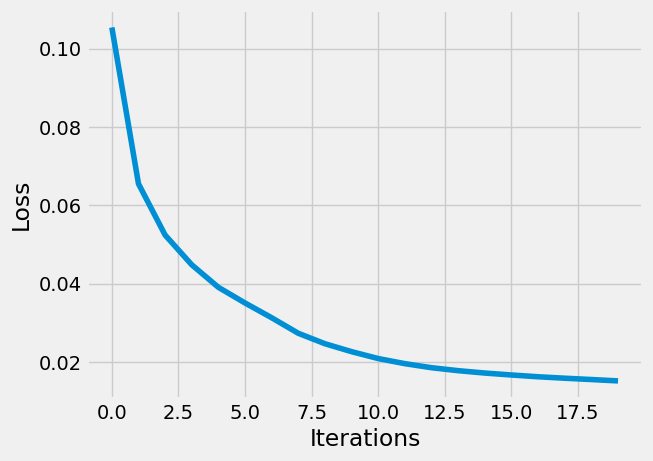

In [103]:
model = autoencoderMLP4().to(device)
loss_f = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
train(num_epochs, optimizer, model, loss_f, dataloader, scheduler, device)

In [105]:
summary(model, input_size=(1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 392]         307,720
            Linear-2                [-1, 1, 16]           6,288
            Linear-3               [-1, 1, 392]           6,664
            Linear-4               [-1, 1, 784]         308,112
Total params: 628,784
Trainable params: 628,784
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.40
Estimated Total Size (MB): 2.41
----------------------------------------------------------------


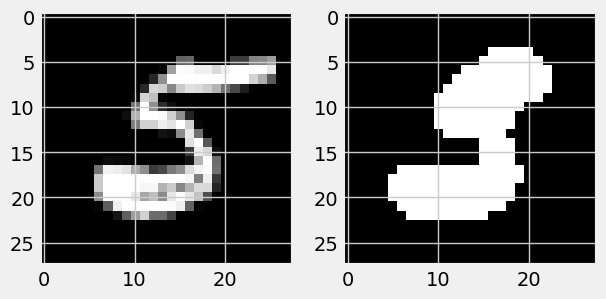

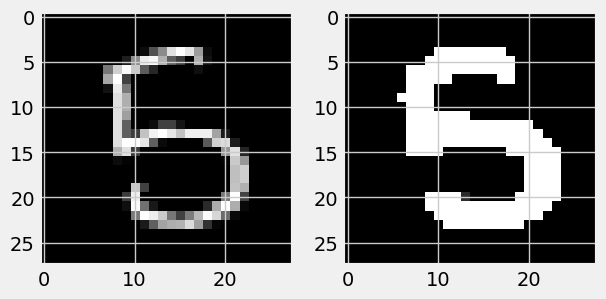

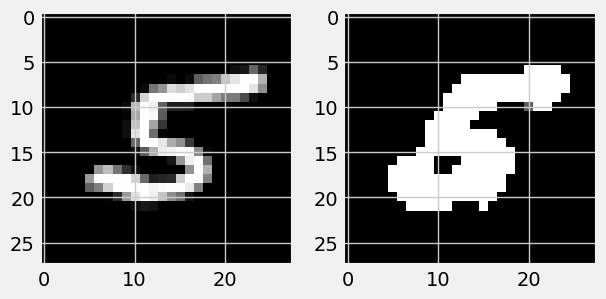

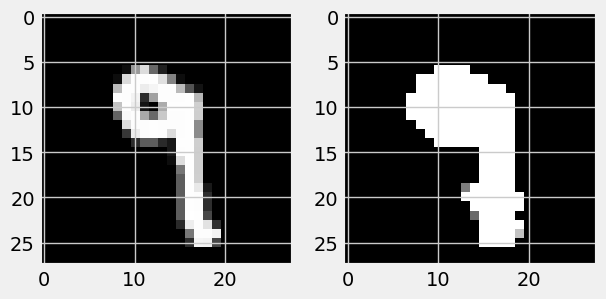

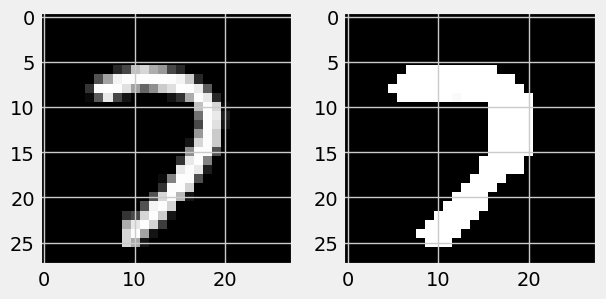

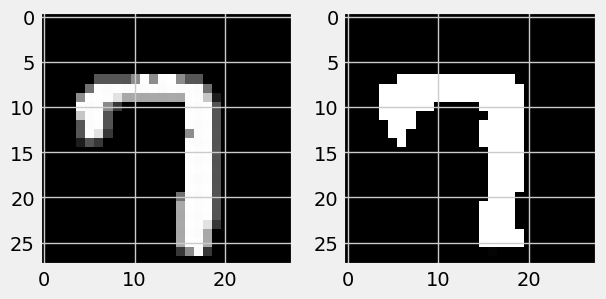

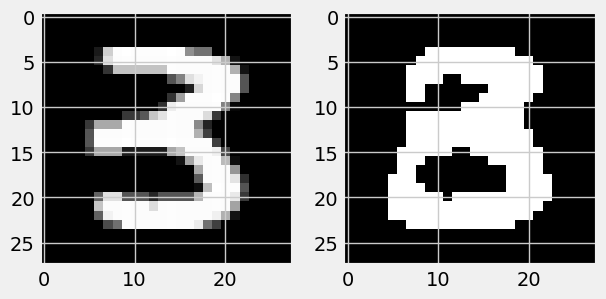

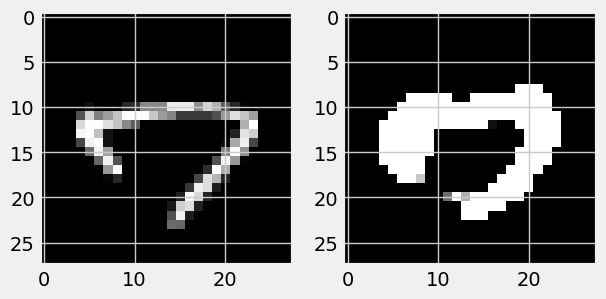

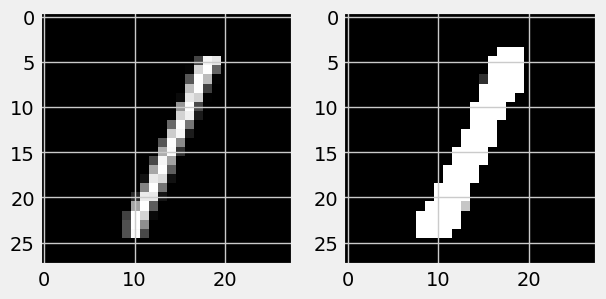

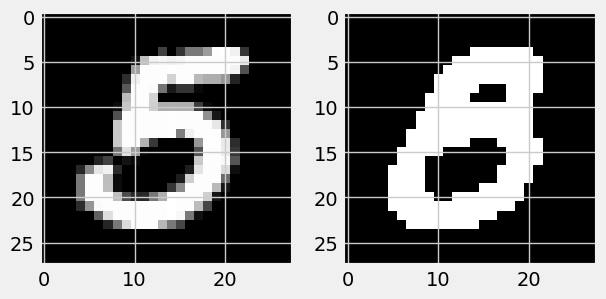

In [107]:
model.eval()

images = []

for i in range(10):
    images.append(train_set.data[np.random.randint(0, len(train_set))])
    
images = torch.stack(images)
images = images.view(images.size(0), -1)
images = images.type(torch.float32)
images = Variable(images).to(device)
with torch.no_grad():
    output = model(images).to(device)

output = output.cpu()
images = images.cpu()
output = output.reshape(-1, 28, 28)
images = images.reshape(-1, 28, 28)

for i in range(10):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(images[i], cmap='gray')
    f.add_subplot(1,2, 2)
    plt.imshow(output[i], cmap='gray')
    plt.show(block=True)